In [1]:
# import module libraries
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

In [2]:
# LSTM with layer normalization
class LayerNormLSTM(nn.Module):
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_i = nn.Linear(input_node, 4*hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4*hidden_node, bias=False)

        self.ln_i = nn.LayerNorm(hidden_node)
        self.ln_f = nn.LayerNorm(hidden_node)
        self.ln_w = nn.LayerNorm(hidden_node)
        self.ln_o = nn.LayerNorm(hidden_node)
        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, input, hidden):
        h_prev, c_prev = hidden

        gi = self.w_i(input)
        gh = self.w_h(h_prev)
        i_i, i_f, i_w, i_o = gi.chunk(4, dim=-1)
        h_i, h_f, h_w, h_o = gh.chunk(4, dim=-1)

        i_g = torch.sigmoid(self.ln_i(i_i + h_i))
        f_g = torch.sigmoid(self.ln_f(i_f + h_f))
        w_g = torch.tanh(self.ln_w(i_w + h_w))
        o_g = torch.sigmoid(self.ln_o(i_o + h_o))
        

        c_new = f_g * c_prev + i_g * w_g
        c_new = self.ln_c(c_new)

        h_new = o_g * torch.tanh(c_new)

        return h_new, c_new

In [3]:
# State feature extractor using LayerNorm LSTM
class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for i in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(hidden_node)

    def forward(self, x, seq_len):
        batch_size, max_len, _ = x.size()
        device = x.device

        h_states = []
        c_states = []

        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))

        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t # initialize layer input with input tensor
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)

        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        normed_output = self.layernorm(masked_output)
        return self.dropout(normed_output)

In [4]:
# Physical change regressor
class PhysRegr(nn.Module):
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.LayerNorm(hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.LayerNorm(hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, output_node))

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)

In [5]:
# Current regressor
class CurrRegr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.LayerNorm(hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.LayerNorm(hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)   

In [6]:
# Physical Constraint Layer
class PhysConstr(nn.Module):
    def __init__(self, range_mm, curr_regr, eps=1e-2):
        super().__init__()
        
        self.eps = eps
        self.curr_regr = curr_regr
        self.register_buffer('range_mm_tensor',self._range2tensor(range_mm))

    def _range2tensor(self, range_mm):
        feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
        ranges = torch.zeros(len(feature_names), 2)

        for i, name in enumerate(feature_names):
            ranges[i, 0] = range_mm[name]['min']
            ranges[i, 1] = range_mm[name]['max']

        return ranges

    def _norm_tensor(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def _denorm_tensor(self, norm_data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return norm_data * (max_val - min_val) + min_val

    def forward(self, phys_chng, cur_state, fin, initV):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self._denorm_tensor(cur_state[..., 2:3], VF_idx)
        VA = self._denorm_tensor(cur_state[..., 3:4], VA_idx)
        VB = self._denorm_tensor(cur_state[..., 4:5], VB_idx)
        CFLA = self._denorm_tensor(cur_state[..., 5:6], CFLA_idx)
        CALA = self._denorm_tensor(cur_state[..., 6:7], CALA_idx)
        CFK = self._denorm_tensor(cur_state[..., 7:8], CFK_idx)
        CBK = self._denorm_tensor(cur_state[..., 8:9], CBK_idx)

        ## Flow in parameters
        FvF, FvA, FvB, CFLA_in, CALA_in, CFK_in, CBK_in = fin

        VFi, VAi, VBi = initV

        dVF_in, dVA_in, dVB_in = FvF, FvA, FvB
        dNFLA_in, dNALA_in, dNFK_in, dNBK_in = FvF * CFLA_in, FvA * CALA_in, FvF * CFK_in, FvB * CBK_in

        dVA = phys_chng[..., 0:1]
        dVB = phys_chng[..., 1:2]
        rratio = phys_chng[..., 2:3]
        dNBK = phys_chng[..., 3:4]

        ## physical boundary: dNALA <= dNBK
        ratio = torch.sigmoid(rratio)
        dNALA = ratio * dNBK

        ## Mass Balance
        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

        ### conservation
        dVA = torch.where(VF < dVA + dVB, torch.zeros_like(dVA), dVA)
        dVB = torch.where(VF < dVA + dVB, torch.zeros_like(dVB), dVB)
        dNALA = torch.where(NFLA < dNALA, torch.zeros_like(dNALA), dNALA)
        dNBK = torch.where(NFK < dNBK, torch.zeros_like(dNBK), dNBK)

        ### new states before discharge
        nVF_bf = VF - dVA - dVB + dVF_in
        nVA_bf = VA + dVA + dVA_in
        nVB_bf = VB + dVB + dVB_in

        nNFLA_bf = NFLA - dNALA + dNFLA_in
        nNALA_bf = NALA + dNALA + dNALA_in
        nNFK_bf = NFK - dNBK + dNFK_in
        nNBK_bf = NBK + dNBK + dNBK_in

        nCFLA = nNFLA_bf / nVF_bf
        nCALA = nNALA_bf / nVA_bf
        nCFK = nNFK_bf / nVF_bf
        nCBK = nNBK_bf / nVB_bf

        dVF_out = torch.clamp(nVF_bf - VFi, min=0.0)
        dVA_out = torch.clamp(nVA_bf - VAi, min=0.0)
        dVB_out = torch.clamp(nVB_bf - VBi, min=0.0)

        nVF = nVF_bf - dVF_out
        nVA = nVA_bf - dVA_out
        nVB = nVB_bf - dVB_out
        
        dNFLA_out, dNFK_out = nCFLA*dVF_out, nCFK*dVF_out

        dNALA_out = nCALA*dVA_out
        dNBK_out = nCBK*dVB_out

        ### Final new states
        nNFLA = nNFLA_bf - dNFLA_out
        nNALA = nNALA_bf - dNALA_out
        nNFK = nNFK_bf - dNFK_out
        nNBK = nNBK_bf - dNBK_out

        V = cur_state[..., 0:1]
        E = cur_state[..., 1:2]

        nVF_norm = self._norm_tensor(nVF, VF_idx)
        nVA_norm = self._norm_tensor(nVA, VA_idx)
        nVB_norm = self._norm_tensor(nVB, VB_idx)
        nCFLA_norm = self._norm_tensor(nCFLA, CFLA_idx)
        nCALA_norm = self._norm_tensor(nCALA, CALA_idx)
        nCFK_norm = self._norm_tensor(nCFK, CFK_idx)
        nCBK_norm = self._norm_tensor(nCBK, CBK_idx)

        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)

        nI_pred = self.curr_regr(temp_state)
        nI_real = self._denorm_tensor(nI_pred, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self._norm_tensor(nI_real, I_idx)

        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)

        ### discharge
        discharge = {
            'VF': dVF_out,
            'VA': dVA_out,
            'VB': dVB_out,
            'NFLA': dNFLA_out,
            'NALA': dNALA_out,
            'NFK': dNFK_out,
            'NBK': dNBK_out,
            'CFLA': nCFLA,
            'CALA': nCALA,
            'CFK': nCFK,
            'CBK': nCBK
        }

        discharge_list = [dVF_out[...,0].item(), dVA_out[...,0].item(), dVB_out[...,0].item(), nCFLA[...,0].item(), nCALA[...,0].item(), nCFK[...,0].item(), nCBK[...,0].item()]

        return next_state, discharge, discharge_list

In [7]:
# BMED model
class BMEDModel(nn.Module):
    def __init__(self, state_extr_params, phys_regr_params, curr_regr_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.phys_regr = PhysRegr(**phys_regr_params)
        self.curr_regr = CurrRegr(**curr_regr_params)
        self.phys_constr = PhysConstr(range_mm, self.curr_regr)

    def _init_hidden_states(self, batch_size, device):
        hidden_states = []
        cell_states =[]

        for _ in range(self.state_extr.n_layer):
            hidden_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))
            cell_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))

        return {'hidden': hidden_states, 'cell': cell_states}

    def _input_stage1(self, fresh_feed, stage2_discharge):
        QF_fresh, CFLA_fresh, CFK_fresh = fresh_feed

        if stage2_discharge is not None:
            VA_from_s2 = stage2_discharge[1]
            VB_from_s2 = stage2_discharge[2]
            CALA_from_s2 = stage2_discharge[4]
            CBK_from_s2 = stage2_discharge[6]
        else:
            VA_from_s2 = VB_from_s2 = 0
            CALA_from_s2 = CBK_from_s2 = 0
        
        return [QF_fresh, VA_from_s2, VB_from_s2, CFLA_fresh, CALA_from_s2, CFK_fresh, CBK_from_s2]
    
    def _input_stage2(self, stage1_discharge, fresh_water):
        QA_fresh, QB_fresh = fresh_water

        if stage1_discharge is not None:
            VF_from_s1 = stage1_discharge[0]
            CFLA_from_s1 = stage1_discharge[3]
            CFK_from_s1 = stage1_discharge[5]
        else:
            VF_from_s1 = 0
            CFLA_from_s1 = CFK_from_s1 = 0

        return [VF_from_s1, QA_fresh, QB_fresh, CFLA_from_s1, 0, CFK_from_s1, 0]
    
    def _check_convergence(self, discharge_1, discharge_2, prev_1, prev_2, tolerance):
        if prev_1 is None or prev_2 is None:
            return False
        
        current_1 = torch.tensor([discharge_1['VF'].item(), discharge_1['VA'].item(), discharge_1['VB'].item(), discharge_1['CFLA'].item(), discharge_1['CALA'].item(), discharge_1['CFK'].item(), discharge_1['CBK'].item()])
        current_2 = torch.tensor([discharge_2['VF'].item(), discharge_2['VA'].item(), discharge_2['VB'].item(), discharge_2['CFLA'].item(), discharge_2['CALA'].item(), discharge_2['CFK'].item(), discharge_2['CBK'].item()])

        prev_1_tensor = torch.tensor(prev_1)
        prev_2_tensor = torch.tensor(prev_2)

        # 상대 변화량으로 수정 (0으로 나누기 방지)
        rel_change_1 = torch.abs((current_1 - prev_1_tensor) / (torch.abs(prev_1_tensor) + 1e-8))
        rel_change_2 = torch.abs((current_2 - prev_2_tensor) / (torch.abs(prev_2_tensor) + 1e-8))

        max_change = max(torch.max(rel_change_1), torch.max(rel_change_2))
        return max_change.item() < tolerance

    def _apply_relaxation(self, old_discharge, new_discharge, relaxation_factor):
        if old_discharge is None:
            return [new_discharge['VF'].item(), new_discharge['VA'].item(), new_discharge['VB'].item(), new_discharge['CFLA'].item(), new_discharge['CALA'].item(), new_discharge['CFK'].item(), new_discharge['CBK'].item()]

        new_values = [new_discharge['VF'].item(), new_discharge['VA'].item(), new_discharge['VB'].item(), new_discharge['CFLA'].item(), new_discharge['CALA'].item(), new_discharge['CFK'].item(), new_discharge['CBK'].item()]

        relaxed = []
        for old_val, new_val in zip(old_discharge, new_values):
            relaxed_val = old_val + relaxation_factor * (new_val - old_val)
            relaxed.append(relaxed_val)

        return relaxed


    def cont_sim(self, init_state_1, init_state_2, target_len, fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation):
        batch_size_1 = init_state_1.size(0)
        feature_size_1 = init_state_1.size(1)
        device_1 = init_state_1.device

        batch_size_2 = init_state_2.size(0)
        feature_size_2 = init_state_2.size(1)
        device_2 = init_state_2.device
        
        state1_states = self._init_hidden_states(batch_size_1, device_1)
        state2_states = self._init_hidden_states(batch_size_2, device_2)

        pred1 = torch.zeros(batch_size_1, target_len, feature_size_1, device=device_1)
        pred2 = torch.zeros(batch_size_2, target_len, feature_size_2, device=device_2)

        discharge_record_1 = []
        discharge_record_2 = []
        convergence_info = []

        stage1_discharge_prev= None
        stage2_discharge_prev = None

        cur_state_1 = init_state_1.clone()
        cur_state_2 = init_state_2.clone()

        for t in range(target_len):
            pred1[:, t, :] = cur_state_1
            pred2[:, t, :] = cur_state_2

            if t < target_len - 1:
                lstm_input_1 = cur_state_1[:, :-1] # except current
                lstm_input_2 = cur_state_2[:, :-1] # except current

                hidden_output_1 = self._lstm_single_step(lstm_input_1, state1_states)
                hidden_output_2 = self._lstm_single_step(lstm_input_2, state2_states)

                phys_chng_1 = self.phys_regr(hidden_output_1.unsqueeze(1))
                phys_chng_2 = self.phys_regr(hidden_output_2.unsqueeze(1))
                cur_state_expanded_1 = cur_state_1.unsqueeze(1)
                cur_state_expanded_2 = cur_state_2.unsqueeze(1)

                converged = False
                iteration = 0

                while not converged and iteration < max_iter:
                    fin_1_coupled = self._input_stage1(fresh_feed, stage2_discharge_prev)
                    fin_2_coupled = self._input_stage2(stage1_discharge_prev, fresh_water)

                    next_state_1, discharge_1, _ = self.phys_constr(
                        phys_chng_1, cur_state_expanded_1, fin_1_coupled, initV
                    )
                    
                    next_state_2, discharge_2, _ = self.phys_constr(
                        phys_chng_2, cur_state_expanded_2, fin_2_coupled, initV
                    )
                    
                    # 수렴 체크 추가
                    converged = self._check_convergence(discharge_1, discharge_2, stage1_discharge_prev, stage2_discharge_prev, tolerance)
                    
                    if not converged:
                        stage1_discharge_prev= self._apply_relaxation(stage1_discharge_prev, discharge_1, relaxation)
                        stage2_discharge_prev = self._apply_relaxation(stage2_discharge_prev, discharge_2, relaxation)

                    iteration += 1
                
                convergence_info.append({
                    'time_step': t,
                    'iteration': iteration,
                    'converged': converged
                })

                cur_state_1 = next_state_1.squeeze(1)
                cur_state_2 = next_state_2.squeeze(1)
                discharge_record_1.append(discharge_1)
                discharge_record_2.append(discharge_2)

        return pred1, pred2, discharge_record_1, discharge_record_2, convergence_info

    def _lstm_single_step(self, x_t, stage_states):
        layer_input = x_t
        hidden_states = stage_states['hidden']
        cell_states = stage_states['cell']

        for layer_idx, lstm_cell in enumerate(self.state_extr.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, (hidden_states[layer_idx], cell_states[layer_idx]))
            
            hidden_states[layer_idx] = h_new
            cell_states[layer_idx] = c_new

            if layer_idx < len(self.state_extr.lstm_cells) - 1:
                layer_input = self.state_extr.dropout(h_new)
            else:
                layer_input = h_new # last layer output

        normed_output = self.state_extr.layernorm(layer_input)
        return self.state_extr.dropout(normed_output)

    def forward(self, init_state_1, init_state_2, target_len, fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation):
        return self.cont_sim(init_state_1, init_state_2, target_len, fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation)

In [8]:
# Utility functions

## Normalize input data with the min-max normalization range of pre-trained model
def normalize(inputs, range_mm):
    features = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK']
    norm = []

    for _, (name, value) in enumerate(zip(features, inputs)):
        min_val = range_mm[name]['min']
        max_val = range_mm[name]['max']
        norm_val = (value - min_val) / (max_val - min_val)
        norm.append(norm_val)
    
    return norm

def denormalize(outputs, range_mm):
    """출력값들을 실제 물리적 값으로 변환"""
    feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    denormalized = np.zeros_like(outputs)
    
    for i, name in enumerate(feature_names):
        if name in range_mm:
            min_val = range_mm[name]['min']
            max_val = range_mm[name]['max']
            denormalized[:, :, i] = outputs[:, :, i] * (max_val - min_val) + min_val
        else:
            denormalized[:, :, i] = outputs[:, :, i]
    
    return denormalized

In [9]:
# Load trained model
model_path = 'BMED_FR_250917.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Model: {model_path}')
print(f'Device: {device}')

model = torch.load(model_path, map_location=device, weights_only=False)
model_config = model['model_config']
state_extr_params = model_config['state_extr_params']
phys_regr_params = model_config['phys_regr_params']
curr_regr_params = model_config['curr_regr_params']
model_range_mm = model_config['range_mm']

simulator = BMEDModel(
    state_extr_params = state_extr_params,
    phys_regr_params = phys_regr_params,
    curr_regr_params = curr_regr_params,
    range_mm = model_range_mm
).to(device)

simulator.load_state_dict(model['model_state_dict'])
simulator.eval()

print('Load model parameters')

Model: BMED_FR_250917.pth
Device: cuda
Load model parameters


In [10]:
# Continuous Simulation Conditions

## cond_init = [V, E, VF, VA, VB, CFLA, CALA, CFK, CBK]
### units = [V, mol/L, L, L, L, mol/L, mol/L, mol/L, mol/L]
cond_init_1 = [30, 0.25, 0.7, 0.7, 0.7, 1, 0, 2, 0]
cond_init_2 = [30, 0.25, 0.7, 0.7, 0.7, cond_init_1[5], 0, cond_init_1[7], 0]
simulation_time = 400 # time step to simulate

## cond_flow = [QF, QA, QB, CFLA, CFK]
### units = [L/step, L/step, L/step, mol/L, mol/L]
### 1 time step  = 0.25 hr
QF, QA, QB = 10, 10, 10 # mL/min

fresh_feed = [QF*60/1000*0.25, cond_init_1[5], cond_init_1[7]]
fresh_water = [QA*60/1000*0.25, QB*60/1000*0.25]

## initial volume = Overflooding volumes
initV = [0.7, 0.7, 0.7] # L

## Normalize
norm_inputs_1 = normalize(cond_init_1, model_range_mm)
norm_inputs_2 = normalize(cond_init_2, model_range_mm)

## initial state
init_normI = 0.0
init_state_values_1 = norm_inputs_1 + [init_normI]
init_state_values_2 = norm_inputs_2 + [init_normI]
init_state_tensor_1 = torch.tensor([init_state_values_1]).float().to(device)
init_state_tensor_2 = torch.tensor([init_state_values_2]).float().to(device)

## Convergence parameters (수정된 값들)
tolerance = 1e-4  # 상대 변화량 기준으로 0.1% 미만
max_iter = 100
relaxation = 0.7  # relaxation factor 증가

In [11]:
# Continuous Simulation
with torch.no_grad():
    pred1, pred2, discharge_record_1, discharge_record_2, convergence_info = simulator(
        init_state_tensor_1,init_state_tensor_2,simulation_time,fresh_feed, fresh_water,initV, tolerance, max_iter,relaxation)

# Check convergence
print('Convergence Summary')
total_iterations = sum([info['iteration'] for info in convergence_info])
failed_convergence = sum([1 for info in convergence_info if not info['converged']])
print(f'Average iteration per time step: {total_iterations/len(convergence_info):.2f}')
print(f'Failed to convergence step: {failed_convergence} / {len(convergence_info)}')

# Post processing
pred_norm_1 = pred1.cpu().numpy()
pred_norm_2 = pred2.cpu().numpy()
pred_real_1 = denormalize(pred_norm_1, model_range_mm)
pred_real_2 = denormalize(pred_norm_2, model_range_mm)

time_steps = np.arange(simulation_time)*0.25

print('Continuous BMED Simulation Complete')

Convergence Summary
Average iteration per time step: 8.57
Failed to convergence step: 0 / 399
Continuous BMED Simulation Complete


In [12]:
# Results
sim_res_1 = {
    'time': time_steps,
    'V': pred_real_1[0, :, 0],
    'E': pred_real_1[0, :, 1], 
    'VF': pred_real_1[0, :, 2],
    'VA': pred_real_1[0, :, 3],
    'VB': pred_real_1[0, :, 4],
    'CFLA': pred_real_1[0, :, 5],
    'CALA': pred_real_1[0, :, 6],
    'CFK': pred_real_1[0, :, 7],
    'CBK': pred_real_1[0, :, 8],
    'I': pred_real_1[0, :, 9]
}

discharge_data_1 = {
    'time': time_steps[:-1],  # discharge는 simulation_time-1 개
    'VF_out': [],
    'VA_out': [],
    'VB_out': [],
    'CFLA_out': [],
    'CALA_out': [],
    'CFK_out': [],
    'CBK_out': [],
    'NFLA_out': [],
    'NALA_out': [],  
    'NFK_out': [],
    'NBK_out': []
}

## Extract discharge results from the record variable
for discharge in discharge_record_1:
    discharge_data_1['VF_out'].append(discharge['VF'].item()/0.25)
    discharge_data_1['VA_out'].append(discharge['VA'].item()/0.25)
    discharge_data_1['VB_out'].append(discharge['VB'].item()/0.25)
    discharge_data_1['CFLA_out'].append(discharge['CFLA'].item())
    discharge_data_1['CALA_out'].append(discharge['CALA'].item())
    discharge_data_1['CFK_out'].append(discharge['CFK'].item())
    discharge_data_1['CBK_out'].append(discharge['CBK'].item())
    discharge_data_1['NFLA_out'].append(discharge['NFLA'].item()/0.25)
    discharge_data_1['NALA_out'].append(discharge['NALA'].item()/0.25)
    discharge_data_1['NFK_out'].append(discharge['NFK'].item()/0.25)
    discharge_data_1['NBK_out'].append(discharge['NBK'].item()/0.25)

In [13]:
# Results
sim_res_2 = {
    'time': time_steps,
    'V': pred_real_2[0, :, 0],
    'E': pred_real_2[0, :, 1], 
    'VF': pred_real_2[0, :, 2],
    'VA': pred_real_2[0, :, 3],
    'VB': pred_real_2[0, :, 4],
    'CFLA': pred_real_2[0, :, 5],
    'CALA': pred_real_2[0, :, 6],
    'CFK': pred_real_2[0, :, 7],
    'CBK': pred_real_2[0, :, 8],
    'I': pred_real_2[0, :, 9]
}

discharge_data_2 = {
    'time': time_steps[:-1],  # discharge는 simulation_time-1 개
    'VF_out': [],
    'VA_out': [],
    'VB_out': [],
    'CFLA_out': [],
    'CALA_out': [],
    'CFK_out': [],
    'CBK_out': [],
    'NFLA_out': [],
    'NALA_out': [],  
    'NFK_out': [],
    'NBK_out': []
}

## Extract discharge results from the record variable
for discharge in discharge_record_2:
    discharge_data_2['VF_out'].append(discharge['VF'].item()/0.25)
    discharge_data_2['VA_out'].append(discharge['VA'].item()/0.25)
    discharge_data_2['VB_out'].append(discharge['VB'].item()/0.25)
    discharge_data_2['CFLA_out'].append(discharge['CFLA'].item())
    discharge_data_2['CALA_out'].append(discharge['CALA'].item())
    discharge_data_2['CFK_out'].append(discharge['CFK'].item())
    discharge_data_2['CBK_out'].append(discharge['CBK'].item())
    discharge_data_2['NFLA_out'].append(discharge['NFLA'].item()/0.25)
    discharge_data_2['NALA_out'].append(discharge['NALA'].item()/0.25)
    discharge_data_2['NFK_out'].append(discharge['NFK'].item()/0.25)
    discharge_data_2['NBK_out'].append(discharge['NBK'].item()/0.25)

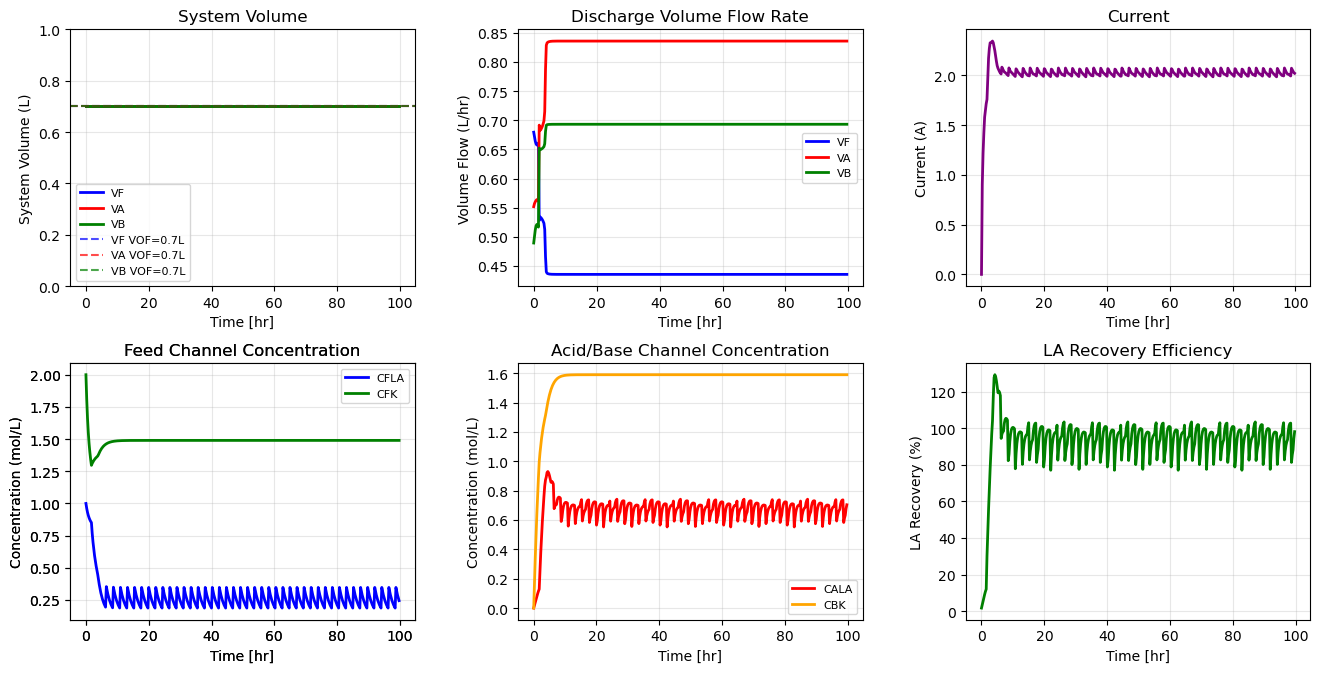

In [14]:
# Visualization
fig = plt.figure(figsize=(16,12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sim_res_1['time'], sim_res_1['VF'], 'b-', label='VF', linewidth=2)
ax1.plot(sim_res_1['time'], sim_res_1['VA'], 'r-', label='VA', linewidth=2)
ax1.plot(sim_res_1['time'], sim_res_1['VB'], 'g-', label='VB', linewidth=2)
ax1.axhline(y=cond_init_1[2], color='b', linestyle='--', alpha=0.7, label=f'VF VOF={cond_init_1[2]}L')
ax1.axhline(y=cond_init_1[3], color='r', linestyle='--', alpha=0.7, label=f'VA VOF={cond_init_1[3]}L')
ax1.axhline(y=cond_init_1[4], color='g', linestyle='--', alpha=0.7, label=f'VB VOF={cond_init_1[4]}L')
ax1.set_xlabel('Time [hr]')
ax1.set_ylabel('System Volume (L)')
ax1.set_title('System Volume')
ax1.set_ylim([0,1])
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(discharge_data_1['time'], discharge_data_1['VF_out'], 'b-', label='VF', linewidth=2)
ax2.plot(discharge_data_1['time'], discharge_data_1['VA_out'], 'r-', label='VA', linewidth=2)
ax2.plot(discharge_data_1['time'], discharge_data_1['VB_out'], 'g-', label='VB', linewidth=2)
ax2.set_xlabel('Time [hr]')
ax2.set_ylabel('Volume Flow (L/hr)')
ax2.set_title('Discharge Volume Flow Rate')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(sim_res_1['time'], sim_res_1['I'], 'purple', linewidth=2)
ax3.set_xlabel('Time [hr]')
ax3.set_ylabel('Current (A)')
ax3.set_title('Current')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(sim_res_1['time'], sim_res_1['CFLA'], 'b-', label='CFLA (Feed LA)', linewidth=2)
ax4.plot(sim_res_1['time'], sim_res_1['CFK'], 'g-', label='CFK (Feed K)', linewidth=2)
ax4.set_xlabel('Time [hr]')
ax4.set_ylabel('Concentration (mol/L)')
ax4.set_title('Feed Channel Concentration')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(sim_res_1['time'], sim_res_1['CFLA'], 'b-', label='CFLA', linewidth=2)
ax4.plot(sim_res_1['time'], sim_res_1['CFK'], 'g-', label='CFK', linewidth=2)
ax4.set_xlabel('Time [hr]')
ax4.set_ylabel('Concentration (mol/L)')
ax4.set_title('Feed Channel Concentration')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(sim_res_1['time'], sim_res_1['CALA'], 'r-', label='CALA', linewidth=2)
ax5.plot(sim_res_1['time'], sim_res_1['CBK'], 'orange', label='CBK', linewidth=2)
ax5.set_xlabel('Time [hr]')
ax5.set_ylabel('Concentration (mol/L)')
ax5.set_title('Acid/Base Channel Concentration')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
input_LA_rate = fresh_feed[0]/0.25 * fresh_feed[1]  # mol/step
recovery_efficiency = np.array(discharge_data_1['NALA_out']) / input_LA_rate * 100
ax6.plot(discharge_data_1['time'], recovery_efficiency, 'green', linewidth=2)
ax6.set_xlabel('Time [hr]')
ax6.set_ylabel('LA Recovery (%)')
ax6.set_title('LA Recovery Efficiency')
ax6.grid(True, alpha=0.3)


In [15]:
#Performance calculation
I_st = sim_res_1['I'][160:180] # A = C/s
C_st = 3600*I_st # C/hr
CE_st = np.array(discharge_data_1['NALA_out'][160:180])*96485/10/C_st*100 # %
Fm_st = np.array(discharge_data_1['NALA_out'][160:180])*90.1 # g/hr
SEC_st = cond_init_1[0]*I_st/Fm_st # Wh/g = kWh/kg
t_st = 1000/Fm_st # hr/kg
E_pump = 0.0047*t_st # kWh/kg
VA_st = np.array(discharge_data_1['VA_out'][160:180]) # L/hr = kg/hr
E_dist = (VA_st *4.184*(100-25)*t_st + (VA_st - Fm_st/0.85/1000)*43.9*1000/18)/3600 # kWh/kg
RR_st = recovery_efficiency[160:180]
TotalE_st = SEC_st + E_pump + E_dist

df_pm1 = pd.DataFrame({
    'RR': np.round(RR_st, 3),
    'SEC': np.round(SEC_st, 3),
    'E_pump': np.round(E_pump, 3),
    'E_dist': np.round(E_dist, 3),
    'TotalE': np.round(TotalE_st, 3)
}).drop_duplicates()
df_pm1 = df_pm1.sort_values(by='RR', ascending=False)
df_pm1

,RR,SEC,E_pump,E_dist,TotalE
17,101.639,1.088,0.086,1.849,3.023
6,99.049,1.127,0.088,1.885,3.099
7,99.017,1.123,0.088,1.885,3.096
8,98.655,1.123,0.088,1.890,3.101
5,98.540,1.138,0.088,1.892,3.118
15,97.737,1.141,0.089,1.903,3.134
16,97.661,1.137,0.089,1.905,3.131
14,97.402,1.150,0.089,1.908,3.148
4,97.188,1.158,0.089,1.911,3.159
13,96.420,1.167,0.090,1.923,3.180


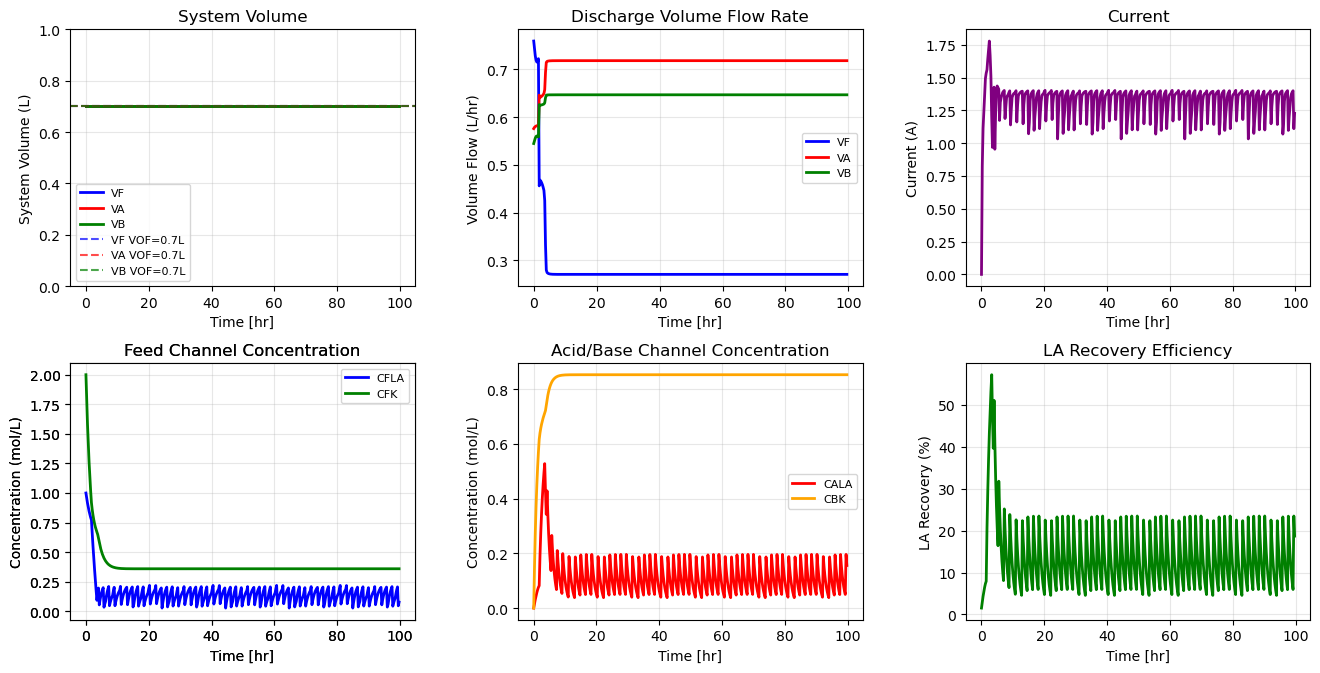

In [16]:
# Visualization
fig = plt.figure(figsize=(16,12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sim_res_2['time'], sim_res_2['VF'], 'b-', label='VF', linewidth=2)
ax1.plot(sim_res_2['time'], sim_res_2['VA'], 'r-', label='VA', linewidth=2)
ax1.plot(sim_res_2['time'], sim_res_2['VB'], 'g-', label='VB', linewidth=2)
ax1.axhline(y=cond_init_2[2], color='b', linestyle='--', alpha=0.7, label=f'VF VOF={cond_init_2[2]}L')
ax1.axhline(y=cond_init_2[3], color='r', linestyle='--', alpha=0.7, label=f'VA VOF={cond_init_2[3]}L')
ax1.axhline(y=cond_init_2[4], color='g', linestyle='--', alpha=0.7, label=f'VB VOF={cond_init_2[4]}L')
ax1.set_xlabel('Time [hr]')
ax1.set_ylabel('System Volume (L)')
ax1.set_title('System Volume')
ax1.set_ylim([0,1])
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(discharge_data_2['time'], discharge_data_2['VF_out'], 'b-', label='VF', linewidth=2)
ax2.plot(discharge_data_2['time'], discharge_data_2['VA_out'], 'r-', label='VA', linewidth=2)
ax2.plot(discharge_data_2['time'], discharge_data_2['VB_out'], 'g-', label='VB', linewidth=2)
ax2.set_xlabel('Time [hr]')
ax2.set_ylabel('Volume Flow (L/hr)')
ax2.set_title('Discharge Volume Flow Rate')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(sim_res_2['time'], sim_res_2['I'], 'purple', linewidth=2)
ax3.set_xlabel('Time [hr]')
ax3.set_ylabel('Current (A)')
ax3.set_title('Current')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(sim_res_2['time'], sim_res_2['CFLA'], 'b-', label='CFLA (Feed LA)', linewidth=2)
ax4.plot(sim_res_2['time'], sim_res_2['CFK'], 'g-', label='CFK (Feed K)', linewidth=2)
ax4.set_xlabel('Time [hr]')
ax4.set_ylabel('Concentration (mol/L)')
ax4.set_title('Feed Channel Concentration')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(sim_res_2['time'], sim_res_2['CFLA'], 'b-', label='CFLA', linewidth=2)
ax4.plot(sim_res_2['time'], sim_res_2['CFK'], 'g-', label='CFK', linewidth=2)
ax4.set_xlabel('Time [hr]')
ax4.set_ylabel('Concentration (mol/L)')
ax4.set_title('Feed Channel Concentration')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(sim_res_2['time'], sim_res_2['CALA'], 'r-', label='CALA', linewidth=2)
ax5.plot(sim_res_2['time'], sim_res_2['CBK'], 'orange', label='CBK', linewidth=2)
ax5.set_xlabel('Time [hr]')
ax5.set_ylabel('Concentration (mol/L)')
ax5.set_title('Acid/Base Channel Concentration')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
input_LA_rate = fresh_feed[0]/0.25 * fresh_feed[1]  # mol/step
recovery_efficiency = np.array(discharge_data_2['NALA_out']) / input_LA_rate * 100
ax6.plot(discharge_data_2['time'], recovery_efficiency, 'green', linewidth=2)
ax6.set_xlabel('Time [hr]')
ax6.set_ylabel('LA Recovery (%)')
ax6.set_title('LA Recovery Efficiency')
ax6.grid(True, alpha=0.3)


In [17]:
#Performance calculation
I_st = sim_res_2['I'][160:180] # A = C/s
C_st = 3600*I_st # C/hr
CE_st = np.array(discharge_data_2['NALA_out'][160:180])*96485/10/C_st*100 # %
Fm_st = np.array(discharge_data_2['NALA_out'][160:180])*90.1 # g/hr
SEC_st = cond_init_1[0]*I_st/Fm_st # Wh/g = kWh/kg
t_st = 1000/Fm_st # hr/kg
E_pump = 0.0047*t_st # kWh/kg
VA_st = np.array(discharge_data_2['VA_out'][160:180]) # L/hr = kg/hr
E_dist = (VA_st *4.184*(100-25)*t_st + (VA_st - Fm_st/0.85/1000)*43.9*1000/18)/3600 # kWh/kg
RR_st = recovery_efficiency[160:180]
TotalE_st = SEC_st + E_pump + E_dist

df_pm2 = pd.DataFrame({
    'RR': np.round(RR_st, 3),
    'SEC': np.round(SEC_st, 3),
    'E_pump': np.round(E_pump, 3),
    'E_dist': np.round(E_dist, 3),
    'TotalE': np.round(TotalE_st, 3)
}).drop_duplicates()
df_pm2 = df_pm2.sort_values(by='RR', ascending=False)
df_pm2

,RR,SEC,E_pump,E_dist,TotalE
17,23.239,3.332,0.374,5.458,9.164
2,22.497,3.459,0.386,5.623,9.468
10,22.342,3.481,0.389,5.658,9.529
18,18.496,3.097,0.470,6.737,10.305
3,17.905,3.622,0.486,6.944,11.052
11,17.782,3.682,0.489,6.989,11.160
19,14.722,4.584,0.591,8.344,13.519
4,14.251,5.009,0.610,8.604,14.223
12,14.153,5.114,0.614,8.660,14.388
5,11.343,6.652,0.766,10.688,18.107


In [18]:
# Mass Balance Verification for 2-Stage BMED System (CORRECTED)

## Calculate mass balance for H2O, K, and LA for each stage separately
# Time step = 0.25 hr, molecular weights: H2O=18 g/mol, K=39.1 g/mol, LA=90.1 g/mol

# Input flows (mol/hr) - Only Stage 1 receives fresh feed
QF_molhr = cond_flow[0] / 0.25  # L/hr
QA_molhr = cond_flow[1] / 0.25  # L/hr  
QB_molhr = cond_flow[2] / 0.25  # L/hr
CFLA_in = cond_flow[3]  # mol/L
CFK_in = cond_flow[5]   # mol/L

# Stage 1 input rates (mol/hr) - Fresh feed only
stage1_H2O_input = (QF_molhr + QA_molhr + QB_molhr) * 1000/18  # assuming water density ~1000g/L
stage1_LA_input = QF_molhr * CFLA_in  # mol/hr
stage1_K_input = QF_molhr * CFK_in    # mol/hr

print(f"=== Stage 1 Input Flow Rates ===")
print(f"H2O input rate: {stage1_H2O_input:.3f} mol/hr")
print(f"LA input rate: {stage1_LA_input:.3f} mol/hr") 
print(f"K input rate: {stage1_K_input:.3f} mol/hr")

# Stage 1 outputs (mol/hr) - ALL OUTPUT STREAMS
stage1_H2O_out = [(discharge_data_1['VF_out'][i] + discharge_data_1['VA_out'][i] + discharge_data_1['VB_out'][i]) * 1000/18 for i in range(len(discharge_data_1['VF_out']))]

# Stage 1 LA outputs: Acid channel (recovered) + Feed channel (to Stage 2)
stage1_LA_acid = discharge_data_1['NALA_out']   # mol/hr (LA recovered in acid channel)
stage1_LA_feed = discharge_data_1['NFLA_out']   # mol/hr (LA going to Stage 2 via feed channel)
stage1_LA_total = [stage1_LA_acid[i] + stage1_LA_feed[i] for i in range(len(stage1_LA_acid))]

# Stage 1 K outputs: Base channel (recovered) + Feed channel (to Stage 2)
stage1_K_base = discharge_data_1['NBK_out']     # mol/hr (K recovered in base channel)
stage1_K_feed = discharge_data_1['NFK_out']     # mol/hr (K going to Stage 2 via feed channel)
stage1_K_total = [stage1_K_base[i] + stage1_K_feed[i] for i in range(len(stage1_K_base))]

# Stage 2 input rates (mol/hr) - ALL CHANNELS from Stage 1
# Stage 2 receives ALL discharge from Stage 1 (Feed, Acid, Base channels)
stage2_H2O_input = stage1_H2O_out  # All H2O from Stage 1
stage2_LA_input = stage1_LA_total  # All LA from Stage 1 (acid + feed)
stage2_K_input = stage1_K_total    # All K from Stage 1 (base + feed)

print(f"\n=== Stage 2 Input Flow Rates (from Stage 1) ===")
print(f"H2O input rate: {np.mean(stage2_H2O_input[160:200]):.3f} ± {np.std(stage2_H2O_input[160:200]):.3f} mol/hr")
print(f"LA input rate: {np.mean(stage2_LA_input[160:200]):.3f} ± {np.std(stage2_LA_input[160:200]):.3f} mol/hr") 
print(f"K input rate: {np.mean(stage2_K_input[160:200]):.3f} ± {np.std(stage2_K_input[160:200]):.3f} mol/hr")

# Stage 2 outputs (mol/hr) - ALL OUTPUT STREAMS
stage2_H2O_out = [(discharge_data_2['VF_out'][i] + discharge_data_2['VA_out'][i] + discharge_data_2['VB_out'][i]) * 1000/18 for i in range(len(discharge_data_2['VF_out']))]

# Stage 2 LA outputs: Acid channel (recovered) + Feed channel (remaining)
stage2_LA_acid = discharge_data_2['NALA_out']   # mol/hr (LA recovered in acid channel)
stage2_LA_feed = discharge_data_2['NFLA_out']   # mol/hr (LA remaining in feed channel)
stage2_LA_total = [stage2_LA_acid[i] + stage2_LA_feed[i] for i in range(len(stage2_LA_acid))]

# Stage 2 K outputs: Base channel (recovered) + Feed channel (remaining)
stage2_K_base = discharge_data_2['NBK_out']     # mol/hr (K recovered in base channel)
stage2_K_feed = discharge_data_2['NFK_out']     # mol/hr (K remaining in feed channel)
stage2_K_total = [stage2_K_base[i] + stage2_K_feed[i] for i in range(len(stage2_K_base))]

# Mass balance errors for each stage separately (%)
# Stage 1 mass balance
stage1_H2O_error = [(stage1_H2O_input - stage1_H2O_out[i])/stage1_H2O_input * 100 for i in range(len(stage1_H2O_out))]
stage1_LA_error = [(stage1_LA_input - stage1_LA_total[i])/stage1_LA_input * 100 for i in range(len(stage1_LA_total))]
stage1_K_error = [(stage1_K_input - stage1_K_total[i])/stage1_K_input * 100 for i in range(len(stage1_K_total))]

# Stage 2 mass balance  
stage2_H2O_error = [(stage2_H2O_input[i] - stage2_H2O_out[i])/stage2_H2O_input[i] * 100 for i in range(len(stage2_H2O_out))]
stage2_LA_error = [(stage2_LA_input[i] - stage2_LA_total[i])/stage2_LA_input[i] * 100 for i in range(len(stage2_LA_total))]
stage2_K_error = [(stage2_K_input[i] - stage2_K_total[i])/stage2_K_input[i] * 100 for i in range(len(stage2_K_total))]

# Overall system outputs (for recovery analysis)
total_LA_recovered = [stage1_LA_acid[i] + stage2_LA_acid[i] for i in range(len(stage1_LA_acid))]
total_K_recovered = [stage1_K_base[i] + stage2_K_base[i] for i in range(len(stage1_K_base))]
total_LA_feed_loss = stage2_LA_feed  # Only Stage 2 feed loss is actual loss
total_K_feed_loss = stage2_K_feed    # Only Stage 2 feed loss is actual loss

print(f"\n=== Steady State Mass Balance Check (t=40-50hr) ===")
ss_start, ss_end = 160, 200  # steady state region

print(f"\n--- Stage 1 Mass Balance ---")
print(f"H2O balance error: {np.mean(stage1_H2O_error[ss_start:ss_end]):.3f} ± {np.std(stage1_H2O_error[ss_start:ss_end]):.3f} %")
print(f"LA balance error: {np.mean(stage1_LA_error[ss_start:ss_end]):.3f} ± {np.std(stage1_LA_error[ss_start:ss_end]):.3f} %")
print(f"K balance error: {np.mean(stage1_K_error[ss_start:ss_end]):.3f} ± {np.std(stage1_K_error[ss_start:ss_end]):.3f} %")

print(f"\n--- Stage 2 Mass Balance ---")
print(f"H2O balance error: {np.mean(stage2_H2O_error[ss_start:ss_end]):.3f} ± {np.std(stage2_H2O_error[ss_start:ss_end]):.3f} %")
print(f"LA balance error: {np.mean(stage2_LA_error[ss_start:ss_end]):.3f} ± {np.std(stage2_LA_error[ss_start:ss_end]):.3f} %")
print(f"K balance error: {np.mean(stage2_K_error[ss_start:ss_end]):.3f} ± {np.std(stage2_K_error[ss_start:ss_end]):.3f} %")

# Visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
fig.suptitle('2-Stage Co-current BMED Mass Balance Verification', fontsize=16, fontweight='bold')

# Stage 1 H2O Mass Balance
axes[0,0].plot(discharge_data_1['time'], stage1_H2O_out, 'b-', label='Stage 1 H2O out', linewidth=2)
axes[0,0].axhline(y=stage1_H2O_input, color='g', linestyle='--', label=f'Stage 1 H2O input: {stage1_H2O_input:.1f} mol/hr', linewidth=2)
axes[0,0].set_xlabel('Time [hr]')
axes[0,0].set_ylabel('H2O Flow Rate [mol/hr]')
axes[0,0].set_title('Stage 1 H2O Mass Balance')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Stage 2 H2O Mass Balance
axes[0,1].plot(discharge_data_2['time'], stage2_H2O_out, 'r-', label='Stage 2 H2O out', linewidth=2)
axes[0,1].plot(discharge_data_1['time'], stage2_H2O_input, 'g--', label='Stage 2 H2O input (ALL from Stage 1)', linewidth=2)
axes[0,1].set_xlabel('Time [hr]')
axes[0,1].set_ylabel('H2O Flow Rate [mol/hr]')
axes[0,1].set_title('Stage 2 H2O Mass Balance')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# LA Mass Balance Flow Distribution
axes[0,2].plot(discharge_data_1['time'], stage1_LA_acid, 'b-', label='Stage 1 LA (acid)', linewidth=2)
axes[0,2].plot(discharge_data_1['time'], stage1_LA_feed, 'b--', label='Stage 1 LA (feed)', linewidth=2)
axes[0,2].plot(discharge_data_2['time'], stage2_LA_acid, 'r-', label='Stage 2 LA (acid)', linewidth=2)
axes[0,2].plot(discharge_data_2['time'], stage2_LA_feed, 'r--', label='Stage 2 LA (waste)', linewidth=2)
axes[0,2].axhline(y=stage1_LA_input, color='g', linestyle='--', label=f'Fresh LA input: {stage1_LA_input:.3f} mol/hr', linewidth=2)
axes[0,2].set_xlabel('Time [hr]')
axes[0,2].set_ylabel('LA Flow Rate [mol/hr]')
axes[0,2].set_title('LA Flow Distribution')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Stage 1 Mass Balance Errors
axes[1,0].plot(discharge_data_1['time'], stage1_H2O_error, 'purple', linewidth=2, label='H2O')
axes[1,0].plot(discharge_data_1['time'], stage1_LA_error, 'orange', linewidth=2, label='LA')
axes[1,0].plot(discharge_data_1['time'], stage1_K_error, 'brown', linewidth=2, label='K')
axes[1,0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,0].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='±5% error')
axes[1,0].axhline(y=-5, color='r', linestyle='--', alpha=0.5)
axes[1,0].set_xlabel('Time [hr]')
axes[1,0].set_ylabel('Mass Balance Error [%]')
axes[1,0].set_title('Stage 1 Mass Balance Errors')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Stage 2 Mass Balance Errors
axes[1,1].plot(discharge_data_2['time'], stage2_H2O_error, 'purple', linewidth=2, label='H2O')
axes[1,1].plot(discharge_data_2['time'], stage2_LA_error, 'orange', linewidth=2, label='LA')
axes[1,1].plot(discharge_data_2['time'], stage2_K_error, 'brown', linewidth=2, label='K')
axes[1,1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,1].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='±5% error')
axes[1,1].axhline(y=-5, color='r', linestyle='--', alpha=0.5)
axes[1,1].set_xlabel('Time [hr]')
axes[1,1].set_ylabel('Mass Balance Error [%]')
axes[1,1].set_title('Stage 2 Mass Balance Errors')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# Overall System Recovery
total_recovery_LA = [total_LA_recovered[i]/stage1_LA_input*100 for i in range(len(total_LA_recovered))]
total_recovery_K = [total_K_recovered[i]/stage1_K_input*100 for i in range(len(total_K_recovered))]
total_loss_LA = [total_LA_feed_loss[i]/stage1_LA_input*100 for i in range(len(total_LA_feed_loss))]
total_loss_K = [total_K_feed_loss[i]/stage1_K_input*100 for i in range(len(total_K_feed_loss))]

axes[1,2].plot(discharge_data_1['time'], total_recovery_LA, 'g-', label='LA Recovery', linewidth=2)
axes[1,2].plot(discharge_data_1['time'], total_recovery_K, 'b-', label='K Recovery', linewidth=2)
axes[1,2].plot(discharge_data_1['time'], total_loss_LA, 'orange', label='LA Loss', linewidth=2)
axes[1,2].plot(discharge_data_1['time'], total_loss_K, 'red', label='K Loss', linewidth=2)
axes[1,2].set_xlabel('Time [hr]')
axes[1,2].set_ylabel('Efficiency [%]')
axes[1,2].set_title('Overall System Recovery & Loss')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

# Stage-wise Recovery Efficiency
stage1_LA_recovery_eff = [stage1_LA_acid[i]/(stage1_LA_acid[i] + stage1_LA_feed[i])*100 for i in range(len(stage1_LA_acid))]
stage2_LA_recovery_eff = [stage2_LA_acid[i]/(stage2_LA_acid[i] + stage2_LA_feed[i])*100 if (stage2_LA_acid[i] + stage2_LA_feed[i]) > 0 else 0 for i in range(len(stage2_LA_acid))]
stage1_K_recovery_eff = [stage1_K_base[i]/(stage1_K_base[i] + stage1_K_feed[i])*100 for i in range(len(stage1_K_base))]
stage2_K_recovery_eff = [stage2_K_base[i]/(stage2_K_base[i] + stage2_K_feed[i])*100 if (stage2_K_base[i] + stage2_K_feed[i]) > 0 else 0 for i in range(len(stage2_K_base))]

axes[2,0].plot(discharge_data_1['time'], stage1_LA_recovery_eff, 'b-', label='Stage 1 LA', linewidth=2)
axes[2,0].plot(discharge_data_2['time'], stage2_LA_recovery_eff, 'r-', label='Stage 2 LA', linewidth=2)
axes[2,0].set_xlabel('Time [hr]')
axes[2,0].set_ylabel('Recovery Efficiency [%]')
axes[2,0].set_title('Stage-wise LA Recovery Efficiency')
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)

axes[2,1].plot(discharge_data_1['time'], stage1_K_recovery_eff, 'b-', label='Stage 1 K', linewidth=2)
axes[2,1].plot(discharge_data_2['time'], stage2_K_recovery_eff, 'r-', label='Stage 2 K', linewidth=2)
axes[2,1].set_xlabel('Time [hr]')
axes[2,1].set_ylabel('Recovery Efficiency [%]')
axes[2,1].set_title('Stage-wise K Recovery Efficiency')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

# Channel Flow Distribution
axes[2,2].bar(['S1 LA\nAcid', 'S1 LA\nFeed', 'S2 LA\nAcid', 'S2 LA\nWaste'], 
              [np.mean(stage1_LA_acid[ss_start:ss_end]), np.mean(stage1_LA_feed[ss_start:ss_end]), 
               np.mean(stage2_LA_acid[ss_start:ss_end]), np.mean(stage2_LA_feed[ss_start:ss_end])],
              color=['blue', 'lightblue', 'red', 'pink'])
axes[2,2].set_ylabel('LA Flow Rate [mol/hr]')
axes[2,2].set_title('LA Channel Flow Distribution (SS)')
axes[2,2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Separation efficiency analysis
print(f"\n=== Separation Efficiency Analysis (Steady State) ===")
overall_LA_recovery = np.mean(total_recovery_LA[ss_start:ss_end])
overall_K_recovery = np.mean(total_recovery_K[ss_start:ss_end])
overall_LA_loss = np.mean(total_loss_LA[ss_start:ss_end])
overall_K_loss = np.mean(total_loss_K[ss_start:ss_end])

print(f"Overall LA Recovery: {overall_LA_recovery:.2f}%")
print(f"Overall K Recovery: {overall_K_recovery:.2f}%")
print(f"Overall LA Loss: {overall_LA_loss:.2f}%")
print(f"Overall K Loss: {overall_K_loss:.2f}%")

# Stage-wise efficiency comparison
stage1_LA_recovery_avg = np.mean(stage1_LA_recovery_eff[ss_start:ss_end])
stage2_LA_recovery_avg = np.mean(stage2_LA_recovery_eff[ss_start:ss_end])
stage1_K_recovery_avg = np.mean(stage1_K_recovery_eff[ss_start:ss_end])
stage2_K_recovery_avg = np.mean(stage2_K_recovery_eff[ss_start:ss_end])

print(f"\n=== Stage-wise Recovery Efficiency ===")
print(f"Stage 1 LA Recovery: {stage1_LA_recovery_avg:.2f}%")
print(f"Stage 2 LA Recovery: {stage2_LA_recovery_avg:.2f}%")
print(f"Stage 1 K Recovery: {stage1_K_recovery_avg:.2f}%")
print(f"Stage 2 K Recovery: {stage2_K_recovery_avg:.2f}%")

# Corrected Mass Balance Summary
mass_balance_summary = pd.DataFrame({
    'Stage': ['Stage 1', 'Stage 1', 'Stage 1', 'Stage 2', 'Stage 2', 'Stage 2'],
    'Component': ['H2O', 'LA', 'K', 'H2O', 'LA', 'K'],
    'Input Rate [mol/hr]': [
        stage1_H2O_input, stage1_LA_input, stage1_K_input,
        np.mean(stage2_H2O_input[ss_start:ss_end]),
        np.mean(stage2_LA_input[ss_start:ss_end]), 
        np.mean(stage2_K_input[ss_start:ss_end])
    ],
    'Output Rate [mol/hr] (SS)': [
        np.mean(stage1_H2O_out[ss_start:ss_end]),
        np.mean(stage1_LA_total[ss_start:ss_end]), 
        np.mean(stage1_K_total[ss_start:ss_end]),
        np.mean(stage2_H2O_out[ss_start:ss_end]),
        np.mean(stage2_LA_total[ss_start:ss_end]), 
        np.mean(stage2_K_total[ss_start:ss_end])
    ],
    'Balance Error [%] (SS)': [
        np.mean(stage1_H2O_error[ss_start:ss_end]),
        np.mean(stage1_LA_error[ss_start:ss_end]),
        np.mean(stage1_K_error[ss_start:ss_end]),
        np.mean(stage2_H2O_error[ss_start:ss_end]),
        np.mean(stage2_LA_error[ss_start:ss_end]),
        np.mean(stage2_K_error[ss_start:ss_end])
    ],
    'Error Std [%]': [
        np.std(stage1_H2O_error[ss_start:ss_end]),
        np.std(stage1_LA_error[ss_start:ss_end]),
        np.std(stage1_K_error[ss_start:ss_end]),
        np.std(stage2_H2O_error[ss_start:ss_end]),
        np.std(stage2_LA_error[ss_start:ss_end]),
        np.std(stage2_K_error[ss_start:ss_end])
    ]
})

print(f"\n=== Corrected Mass Balance Summary (Stage-wise) ===")
print(mass_balance_summary.round(4))

# Validation check
stage1_LA_balance_avg = np.mean(stage1_LA_error[ss_start:ss_end])
stage1_K_balance_avg = np.mean(stage1_K_error[ss_start:ss_end])
stage1_H2O_balance_avg = np.mean(stage1_H2O_error[ss_start:ss_end])
stage2_LA_balance_avg = np.mean(stage2_LA_error[ss_start:ss_end])
stage2_K_balance_avg = np.mean(stage2_K_error[ss_start:ss_end])
stage2_H2O_balance_avg = np.mean(stage2_H2O_error[ss_start:ss_end])

print(f"\n=== Mass Balance Validation ===")
all_errors = [abs(stage1_LA_balance_avg), abs(stage1_K_balance_avg), abs(stage1_H2O_balance_avg),
              abs(stage2_LA_balance_avg), abs(stage2_K_balance_avg), abs(stage2_H2O_balance_avg)]

if all(error < 5.0 for error in all_errors):
    print("✅ Mass balance validation PASSED for all components and stages (error < 5%)")
    print("   - Each stage balanced individually against its inputs")
    print("   - Stage 1: Fresh feed input vs. total output")
    print("   - Stage 2: ALL Stage 1 discharge vs. Stage 2 total output")
else:
    print("❌ Mass balance validation FAILED for some components/stages (error ≥ 5%)")
    if abs(stage1_LA_balance_avg) >= 5.0:
        print(f"   - Stage 1 LA balance error: {stage1_LA_balance_avg:.2f}%")
    if abs(stage1_K_balance_avg) >= 5.0:
        print(f"   - Stage 1 K balance error: {stage1_K_balance_avg:.2f}%")
    if abs(stage1_H2O_balance_avg) >= 5.0:
        print(f"   - Stage 1 H2O balance error: {stage1_H2O_balance_avg:.2f}%")
    if abs(stage2_LA_balance_avg) >= 5.0:
        print(f"   - Stage 2 LA balance error: {stage2_LA_balance_avg:.2f}%")
    if abs(stage2_K_balance_avg) >= 5.0:
        print(f"   - Stage 2 K balance error: {stage2_K_balance_avg:.2f}%")
    if abs(stage2_H2O_balance_avg) >= 5.0:
        print(f"   - Stage 2 H2O balance error: {stage2_H2O_balance_avg:.2f}%")

# System performance summary
print(f"\n=== 2-Stage Co-current System Performance Summary ===")
print(f"Overall LA Recovery: {overall_LA_recovery:.2f}% (Stage 1: {stage1_LA_recovery_avg:.1f}%, Stage 2: {stage2_LA_recovery_avg:.1f}%)")
print(f"Overall K Recovery: {overall_K_recovery:.2f}% (Stage 1: {stage1_K_recovery_avg:.1f}%, Stage 2: {stage2_K_recovery_avg:.1f}%)")
print(f"Final LA Loss: {overall_LA_loss:.2f}%")
print(f"Final K Loss: {overall_K_loss:.2f}%")
print(f"Stage 1 → Stage 2 total transfer:")
print(f"  - H2O: {np.mean(stage1_H2O_out[ss_start:ss_end]):.3f} mol/hr")
print(f"  - LA: {np.mean(stage1_LA_total[ss_start:ss_end]):.3f} mol/hr")
print(f"  - K: {np.mean(stage1_K_total[ss_start:ss_end]):.3f} mol/hr")

NameError: name 'cond_flow' is not defined